# verifying cartesian cutting plane intersection geometry

yt [PR#4847](https://github.com/yt-project/yt/pull/4847) introduces a cartesian cutting plane object that allows you to sample a spherical dataset on an arbitrary cartesian plane. 

This notebook runs a range of tests to check that the area of intersection between the cartesian cutting planes and the spherical dataset is correct. 

For all tests, the approximate area of intersection is calculated by taking returning a fixed resulotion buffer (FRB) of the `ds.cartesian_cutting` object for the `('index', 'ones')` field and calculating the area by summing the FRB and multiplying by the area of each FRB cell. The actual area is calculated by finding the 2 radii of the circles of intersection between the plane and the spheres defined by the minimum and maximum radial extent of the dataset and then calculating the area between the two concentric circles, $\pi(r_{max}^2 - r_{min}^2)$.

There are a number of parameters that are tested here
* FRB resolution: should see convergence to actual area as FRB resolution increases
* Plane positioning: should be able to move the plane with reasonablly little change to accuracy
* Dataset bounds: when $r_{min}>0$, should return the area of the resulting annulus
* Dataset resolution: this doesn't actualy impact results but was tested.

### Requirements:
* Requires the branch associated with the above PR.
* dask[array,distributed]

### Test function helpers

The following functions, `get_ds` and `area_of_intersection` are used to generate a dataset in spherical coordinates and then calculate the area of intersection between the resulting dataset and a specifiec cartesian cutting plane. 

Note that the yt log level is set to 0 so that dask can run with multiple threads. 

In [1]:
import numpy as np
import yt
from yt.testing import fake_amr_ds
import matplotlib.pyplot as plt
from dask import delayed, compute
from dask import array as da
from dask.distributed import client
import matplotlib.pyplot as plt 

yt.set_log_level(0)  

def get_ds(shp, r_max = 1.0, r_min = 0.0):
    data = {"density": np.random.random(shp)}

    bbox = np.array([[r_min, r_max], [0, np.pi], [0, 2 * np.pi]])
    
    ds = yt.load_uniform_grid(
        data,
        shp,
        bbox=bbox,
        geometry="spherical",
        axis_order=("r", "theta", "phi"),
        length_unit="m",
    )
    return ds 

def area_of_intersection(data_shp, normal, center, frb_res, frb_wid=2.0, r_max = 1.0, r_min = 0.0):

    ds = get_ds(data_shp, r_max=r_max, r_min=r_min)
    
    # construct slice, get frb of ones field 
    slc = ds.cartesian_cutting(normal, center)    
    frb = slc.to_frb(frb_wid, frb_res)
    vals = frb["index", "ones"]
    msk = frb.get_mask(("index", "ones"))
    vals[~msk] = 0.0
    
    # get the approximate area 
    dx = (frb.bounds[1] - frb.bounds[0]) / frb.buff_size[0]
    dy = (frb.bounds[3] - frb.bounds[2]) / frb.buff_size[1]
    area_approx = vals.sum() * dx * dy 
    area_approx = float(area_approx.d)

    # calculate actual area, assuming radius goes  
    d = np.abs(slc.selector.d) # shortest distance to plane 
    r_max = ds.domain_right_edge[0].d
    r_min = ds.domain_left_edge[0].d
    if d >= r_max:
        # no intersection
        area_actual = 0.0
    else:
        # radius of intersection with outer extent
        r_circ_max = np.sqrt(r_max**2 - d**2)
    
        if d >= r_min:
            # no intersection with inner extent
            r_circ_min = 0.0 
        else:
            # radius of intersection with inner exent
            r_circ_min = np.sqrt(r_min**2 - d**2)
            
        area_actual = np.pi * (r_circ_max**2 - r_circ_min**2)        

    errorval = np.abs(area_approx - area_actual)
    if area_actual != 0:
        errorval = errorval / area_actual 
    return area_approx, area_actual, errorval

## Test 1: frb resolution convergence

In [2]:
shp = (128, 128, 128)
normal = np.array([1.0, 1.0, 1.0])
center = np.array([0.0, 0., 0.])
frb_vals = np.logspace(1,3.2,100).astype(int)

results = []
for frb_res in frb_vals:
    results.append(delayed(area_of_intersection)(shp, normal, center, frb_res))

results = np.array(compute(*results))

approx_area  = results[:,0]
actual_area = results[:,1]
area_err = results[:,2]

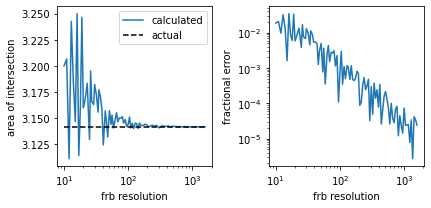

In [3]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
axs[0].plot(frb_vals, approx_area, label='calculated')
# actual area here does not differ
axs[0].semilogx([frb_vals[0], frb_vals[-1]],[actual_area[0], actual_area[0]],'--k', label='actual')
axs[0].set_ylabel('area of intersection')
axs[0].set_xlabel('frb resolution')
axs[0].legend()

axs[1].loglog(frb_vals, area_err)
axs[1].set_ylabel('fractional error')
axs[1].set_xlabel('frb resolution')
plt.tight_layout()
plt.show()

error decreases as frb resolution increases (as expected). Error reduces to less that ~1% above a resolution of ~100.

## Test 2: vary plane origin

take a plane normal to (1,1,1) and shift it from close to the origin to out past the max radius

In [4]:
dvals = np.linspace(0.0, 1 + 0.05, 100)  # origin-plane closest approach 
shp = (128, 128, 128)
normal = np.array([1.0, 1.0, 1.0])
frb_res = 800

results = []
for d in dvals:
    xyz = np.sqrt(d/3) # x = y = z along 1,1,1 normal
    center = np.array([xyz, xyz, xyz])     
    results.append(delayed(area_of_intersection)(shp, normal, center, frb_res))

results = np.array(compute(*results))

approx_area  = results[:,0]
actual_area = results[:,1]
area_err = results[:,2]

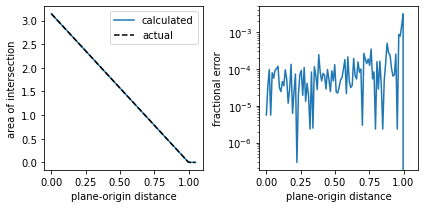

In [5]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
axs[0].plot(dvals, approx_area, label='calculated')
# actual area here does not differ
axs[0].plot(dvals, actual_area,'--k', label='actual')
axs[0].set_ylabel('area of intersection')
axs[0].set_xlabel('plane-origin distance')
axs[0].legend()

axs[1].semilogy(dvals, area_err)
axs[1].set_ylabel('fractional error')
axs[1].set_xlabel('plane-origin distance')
plt.tight_layout()
plt.show()

a rolling mean of the fractional error might indicate an increase as the origin-plane distance approaches the maximum radius, but most of the range is less than 1e-4, and drops to identically 0 as the plane passes beyond the outer radius. 

## Test 3: vary inner radius bound of dataset

Fix the plane at x=0.5, normal to x unit vector and increase the mininum r of the dataset's bounding box.

Increasing min r shouldn't have any effect until the min r is >= 0.5. 

In [6]:
rmin_vals = np.linspace(0, 0.8, 100)
shp = (128, 128, 128)
normal = np.array([1.0, 0.0, 0.0])
center = np.array([0.5, 0.0, 0.0])
frb_res = 800
frb_wid = 2.0
r_max = 1.0
results = []
for r_min in rmin_vals:    
    results.append(delayed(area_of_intersection)(shp, normal, center, frb_res, frb_wid, r_max, r_min))

results = np.array(compute(*results))

approx_area  = results[:,0]
actual_area = results[:,1]
area_err = results[:,2]

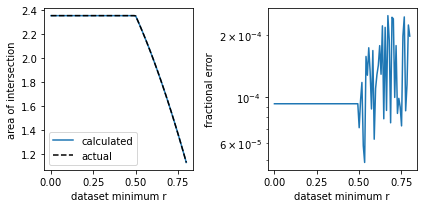

In [7]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
axs[0].plot(rmin_vals, approx_area, label='calculated')
# actual area here does not differ
axs[0].plot(rmin_vals, actual_area,'--k', label='actual')
axs[0].set_ylabel('area of intersection')
axs[0].set_xlabel('dataset minimum r')
axs[0].legend()

axs[1].semilogy(rmin_vals, area_err)
axs[1].set_ylabel('fractional error')
axs[1].set_xlabel('dataset minimum r')
plt.tight_layout()
plt.show()

as expected, there is no effect of increasing the minimum radius of the dataset bounds until it increases past the position of the plane, after which the area of intersection (the annulus defined by the circles at the min and max radii of intersection) decreases without any obvious systematic impact on error. 

## Test 4: dataset resolution 

For completeness, worth checking the effect of the dataset's underlying resolution. Turns out it doesn't have any effect! Was initially surprised, but after some thought it makes sense: the frb will set its sample points independent of the dataset's resolution, but if the bounds of the data are not changing then the same number of frb points will always fall within the dataset bounds. 

In [8]:
normal = np.array([1.0, 1.0, 1.0])
center = np.array([0.0, 0., 0.])
frb_res = 400
data_res = (2**np.linspace(4,8,20)).astype(int)

results = []
for res in data_res:
    shp = (res,)*3
    results.append(delayed(area_of_intersection)(shp, normal, center, frb_res))

results = np.array(compute(*results))

approx_area  = results[:,0]
actual_area = results[:,1]
area_err = results[:,2]

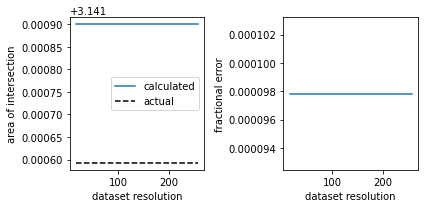

In [9]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
axs[0].plot(data_res, approx_area, label='calculated')
# actual area here does not differ
axs[0].plot([data_res[0], data_res[-1]],[actual_area[0], actual_area[0]],'--k', label='actual')
axs[0].set_ylabel('area of intersection')
axs[0].set_xlabel('dataset resolution')
axs[0].legend()

axs[1].plot(data_res, area_err)
axs[1].set_ylabel('fractional error')
axs[1].set_xlabel('dataset resolution')
plt.tight_layout()
plt.show()